In [21]:
# !pip install -Uqq fastbook
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila
import fastbook
fastbook.setup_book()

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.9 OK


In [5]:
from fastbook import *
from fastai.vision.widgets import *

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY','cdf219bc69cd4a249e4ad27b0e400b5e')

In [ ]:
categories = 'dog','cat','fox'
path = Path('ch2')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in categories:
        dest = (path/o)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, o)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
fns

(#414) [Path('ch2/dog/00000005.jpg'),Path('ch2/dog/00000087.jpg'),Path('ch2/dog/00000014.jpg'),Path('ch2/dog/00000066.jpg'),Path('ch2/dog/00000104.jpg'),Path('ch2/dog/00000111.jpg'),Path('ch2/dog/00000141.jpg'),Path('ch2/dog/00000030.jpg'),Path('ch2/dog/00000001.jpg'),Path('ch2/dog/00000117.png')...]

In [ ]:
failed = verify_images(fns)
failed

(#6) [Path('ch2/dog/00000131.jpg'),Path('ch2/fox/00000003.jpg'),Path('ch2/fox/00000146.jpg'),Path('ch2/cat/00000012.jpg'),Path('ch2/cat/00000124.jpg'),Path('ch2/cat/00000092.jpg')]

In [ ]:
failed.map(Path.unlink)

(#6) [None,None,None,None,None,None]

In [ ]:
dog_cat_fox = DataBlock(blocks =(ImageBlock, CategoryBlock),
                        get_items = get_image_files,
                        splitter = RandomSplitter(valid_pct = 0.2, seed=40),
                        get_y = parent_label,
                        item_tfms = RandomResizedCrop(224, min_scale=0.5),
                        batch_tfms=aug_transforms(mult=2))

In [ ]:
dls = dog_cat_fox.dataloaders(path)

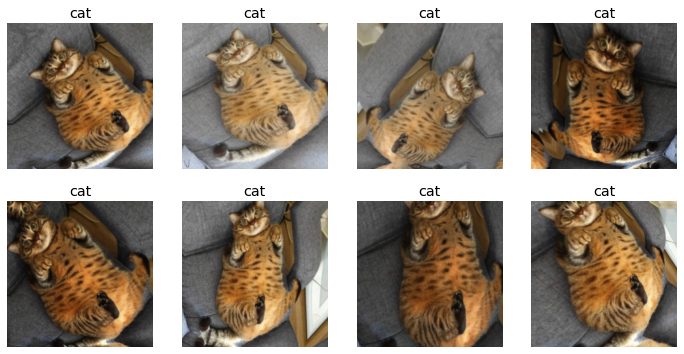

In [ ]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


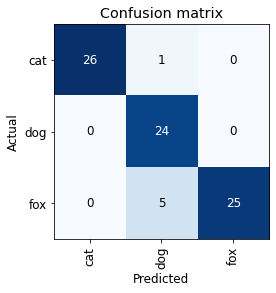

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

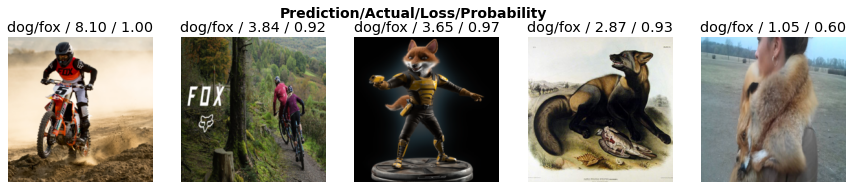

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
dog_cat_fox = DataBlock(blocks =(ImageBlock, CategoryBlock),
                        get_items = get_image_files,
                        splitter = RandomSplitter(valid_pct = 0.2, seed=40),
                        get_y = parent_label,
                        item_tfms = RandomResizedCrop(224, min_scale=0.5),
                        batch_tfms=aug_transforms(mult=2))
dls = dog_cat_fox.dataloaders(path)
learn = cnn_learner(dls,resnet18,metrics=error_rate)
learn.fine_tune(10)

In [ ]:
learn.export()

In [ ]:
path =Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [14]:
learn_inf = load_learner('export.pkl')

In [ ]:
learn_inf.predict('fox.jpg')

('fox', tensor(2), tensor([3.4889e-05, 3.9877e-05, 9.9993e-01]))

In [ ]:
learn_inf.dls.vocab

['cat', 'dog', 'fox']

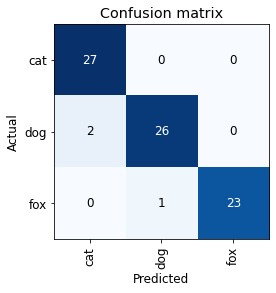

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Dog, Cat , Fox image classifier

In [7]:
btn_upload = widgets.FileUpload()

In [8]:
out_pl = widgets.Output()
out_pl.clear_output()

In [9]:
lbl_pred = widgets.Label()

In [10]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [19]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04}'
    
btn_run.on_click(on_click_classify)

In [20]:
VBox([widgets.Label('Select your image!'),
      btn_upload, btn_run, out_pl,lbl_pred])